# 1D CME simulation to determine cell polarization via a signalling pathway
nicole pagane
2/15/17

### import necessary modules

In [147]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.integrate as snt
import scipy.stats as stats
from scipy.optimize import curve_fit
import os
import plotly.plotly as py
import plotly.graph_objs as go
from decimal import Decimal
from matplotlib.colors import LogNorm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### parameters

In [148]:
#radius of substrate (assume the kinase is of similar size)
r = 1e-9 #m

#one-dimensional length of lattice gradient
L = 1.0e-3 #m

#number of compartments **INCLUDING THE 2 CONSTANT BOUNDARY SUBVOLUMES AND 3 CENTRAL SUBVOLUMES OF THE CELL**
K = 9

#large number n for how many timesteps to use for plotting
n = 100

#sample space range for parameter scan of kinetic rate constants
s0 = 1e-2
s1 = 1
slen = 20

#original far left and far right compartment species numbers
N = {}
N['A'] = np.asarray([20, 100])

#initial number of kinase molecules
c2 = 100

#initial number of singly phosphoylated kinase molecules
c3 = 100

#initial number of doubly phosphorylated kinase molecules
c4 = 60

# filename for parameter trials
paramFile = "parameterMatrix.dat"
odeFile = "parameterTrial.dat"

#set to False for holistic (slow) parameter search or True for quick
quick = True

### setup for deterministic solution to cell signalling pathway 

In [149]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
#     K -> Kp      (k2)
#    Kp -> K       (k3)
#    Kp -> Kpp     (k4)
#   Kpp -> Kp      (k5)
nReac = 5
nSpec = 4

# define intital values and parameters for the above kinetic rate laws
# model the concentration of substrate as a linear gradient 
c1 = 0 # technically N['A'][0] is the correct initial concentration if looking at the boundary
       # but lets assume 0 for the next right cell 
V = 1
y0 = np.asarray([c1, c2, c3, c4])/V #initial species concentration

params = {}
paramRange = np.linspace(s0, s1, slen)

#there should be paramRange^params columns so in our case len(paramRange)^nReac
if not quick:
    cols = len(paramRange)**nReac
else:
    cols = len(paramRange)**3

params['k1'] = np.zeros(cols)
params['k2'] = np.zeros(cols)
params['k3'] = np.zeros(cols)
params['k4'] = np.zeros(cols)
params['k5'] = np.zeros(cols)

keys = ['k1', 'k2', 'k3', 'k4', 'k5']

if quick:
    params['k1'] = np.ones(cols)*1e-2
    params['k2'] = np.ones(cols)*1e-3


ti = 0
tf = 10
t = np.linspace(ti, tf, n)

# define rates equations
def rates(y, t, k1, k2, k3, k4, k5):
    return np.asarray([c1 + (N['A'][1] - N['A'][0])*(L/(K-2))/L, 
                       -k1*y[0]*y[1] - k2*y[1] + k3*y[2],
                       k1*y[0]*y[1] + k2*y[1] - k3*y[2] - k4*y[2] + k5*y[3],
                       k4*y[2] -  k5*y[3]])

### parameter scan setup

In [151]:
# check to see if there are parameter files to avoid having to run the next section
files = os.listdir(".")
if paramFile not in files:
    print("the parameter permutations have not been created"
          "\nthis may take a bit of time dependent on the given parameter range")
    runPerm = True
else:
    print('the parameter permutations have already been created')
    runPerm = False
    FID = open(paramFile, 'r')
    data = FID.readlines()
    for i in range(len(data)):
        data[i] = data[i].strip()
        data[i] = data[i].split()
        for j in range(len(keys)):
            params[keys[j]][i] = float(data[i][j])
    #close file now that data has been read in
    FID.close()
    print('parameter file read in')
        

the parameter permutations have not been created
this may take a bit of time dependent on the given parameter range


In [152]:
# the first parameter is the longest to set up, time improves for each successive parameter
# TIME IS ONLY AN ISSUE IF HOLISTIC SEARCH IS DONE
if runPerm:
    if not quick:
        iter = range(len(keys))
    else:
        iter = [0,1,2]
    for par in iter:
        indStart = 0
        while indStart < cols:
            val = 0
            while val < len(paramRange):
                indEnd = indStart + len(paramRange)**(par) + 1
                if (quick and par == 0):
                    par = 3 - 1 #index of k3
                elif (quick and par == 1):
                    par = 4 - 1 #index of k4
                elif (quick and par == 2):
                    par = 5 -1 #index of k5
                params[keys[par]][indStart:indEnd] = paramRange[val]
                val += 1
                indStart = indEnd 
                if (quick and par == 2):
                    par = 0 #return back to expected par value
                elif (quick and par == 3):
                    par = 1 #return back to expected par value
                elif (quick and par == 4):
                    par = 2 #return back to expected par value
        #print(float(par+1)/len(params.keys()))
    #save permutations file to avoid having to run the above code more than once
    print('writing parameters to file to avoid having to run again')
    FID = open(paramFile, 'w')
    for i in range(len(params['k1'])):
        line = [];
        for j in range(len(keys)):
            line.append(str(params[keys[j]][i]))
        FID.write(' '.join(line))
        FID.write('\n')
    #close file now that data has been read in
    FID.close()
    print('done')


writing parameters to file to avoid having to run again
done


### test the parameter combinations to find acceptable range

In [153]:
# create a dictionay to hold ODE values for each parameter combination trial
odeTrials = {}

# check to see if there is an ODE file to avoid having to run the next section
files = os.listdir(".")
if odeFile not in files:
    print("finding the numerical solutions to the system of ODEs")
    for i in range(len(params['k1'])):
        k1 = params['k1'][i]
        k2 = params['k2'][i]
        k3 = params['k3'][i]
        k4 = params['k4'][i]
        k5 = params['k4'][i]
        ode = snt.odeint(rates, y0,t, args = (k1, k2, k3, k4, k5))
        odeTrials[i] = ode
    print('done')
    print('writing the solutions to a file')
    FID = open(odeFile, 'w')
    for i in range(len(odeTrials.keys())):
        FID.write(' '.join([str(params['k1'][i]), str(params['k2'][i]), str(params['k3'][i]), 
                            str(params['k4'][i]), str(params['k5'][i])]))
        FID.write('\n')
        for j in range(len(odeTrials[i])):
            line = [];
            for k in range(nSpec):
                line.append(str(odeTrials[i][j][k]))
            FID.write(' '.join(line))
            FID.write('\n')
        FID.write('\n')
    #close file now that data has been read in
    FID.close()
    print('done')
else:
    print('the numerical solutions have been found\nreading in the file')
    FID = open(odeFile, 'r')
    data = FID.readlines()
    ind = 0;
    odeInd = 0;
    for i in range(len(params['k1'])):
        ind = ind + 1
        odeTrials[i] = np.asarray(np.zeros(n*nSpec).reshape([n, nSpec]))
        for j in range(n):
            data[ind] = data[ind].strip()
            data[ind] = data[ind].split()
            for k in range(nSpec):
                odeTrials[odeInd][j][k] = float(data[ind][k])
            ind = ind + 1
        odeInd = odeInd + 1
        ind = ind + 1
    #close file now that data has been read in
    FID.close()
    print('parameter file read in')

finding the numerical solutions to the system of ODEs
done
writing the solutions to a file
done


### plot kp by kpp with different differentials to represent the density

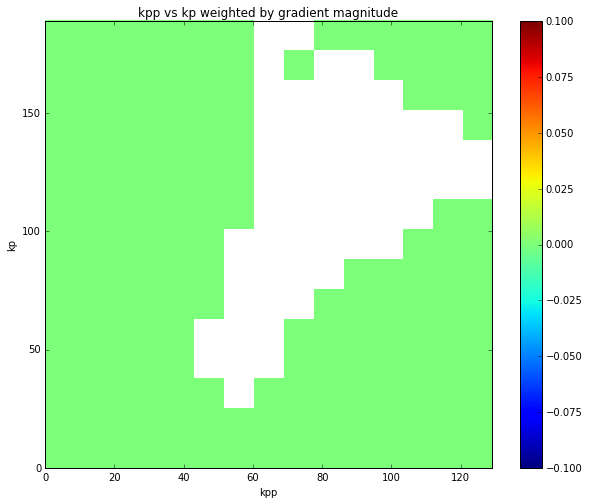

In [157]:
fig = plt.figure(figsize=(10,8))

k = np.zeros(len(params['k1'])*n-1)
kp = np.zeros(len(params['k1'])*n-1)
kpp = np.zeros(len(params['k1'])*n-1)
dk = np.zeros(len(params['k1'])*n-1)
dkp = np.zeros(len(params['k1'])*n-1)
dkpp = np.zeros(len(params['k1'])*n-1)
#generate the differentials and append all trials to one vector
ind = 0
for i in range(len(params['k1'])):
    k[ind:ind+n-1] = odeTrials[i][0:n-1,1]
    kp[ind:ind+n-1] = odeTrials[i][0:n-1,2]
    kpp[ind:ind+n-1] = odeTrials[i][0:n-1,3]
    dk[ind:ind+n-1] = np.diff(odeTrials[i][:,1])/np.diff(t)
    dkp[ind:ind+n-1] = np.diff(odeTrials[i][:,2])/np.diff(t)
    dkpp[ind:ind+n-1] = np.diff(odeTrials[i][:,3])/np.diff(t)
    ind = ind+n-1

plt.hist2d(kpp, kp, bins = 15, cmax = 10, cmap = 'jet', weights = dk**2 + dkp**2 + dkpp**2, normed = False)
plt.xlabel('kpp')
plt.ylabel('kp')
plt.title('kpp vs kp weighted by gradient magnitude')
plt.colorbar()

plt.show()

100

### plot dkpp/dt for the numerical solutions of the kinetic laws to determine best fit parameters

In [156]:
#ok i dont really like this but this has to be very user heavy with necessary input
#generate length 100 arrays to look at the interactive plot with
trials = []
count = 0
while count + 100 <= cols:
    trials.append([count, count + 100])
    count = count + 100
print len(trials) - 1
print "k1 = ", params['k1'][0]
print "k2 = ", params['k2'][0]

att = 1 # CHANGE THIS NUMBER HERE TO SEE THE PLOTS FOR A LIMITED SELECTION OF SOLUTIONS 

#create traces
data = []
for i in range(trials[att][0], trials[att][1]):
    dkpp = np.diff(odeTrials[i][:,3])/np.diff(t)
    trace = go.Scatter(
    x = odeTrials[i][:,3][0:n-1],
    y = dkpp,
    mode = 'lines',
    name = ''.join([str('%.2E' % Decimal(params['k3'][i])), ", ", str('%.2E' % Decimal(params['k4'][i],2)), 
                   ", ", str('%.2E' % Decimal(params['k5'][i],2))])
    )
    data.append(trace)

py.iplot(data, filename='scatter-mode')

79
k1 =  0.01
k2 =  0.001
High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~peptime/0 or inside your plot.ly account where it is named 'scatter-mode'


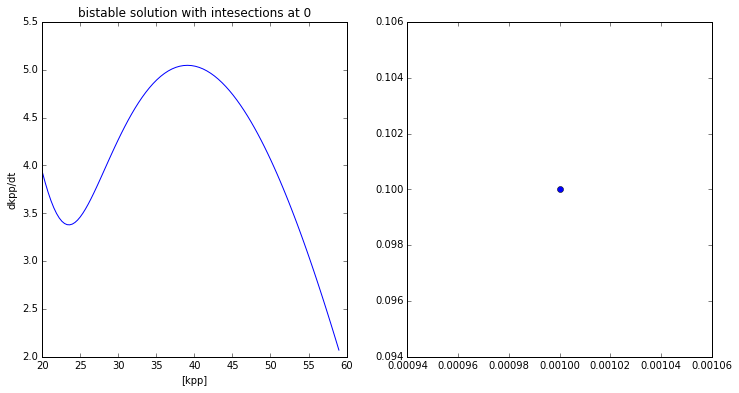

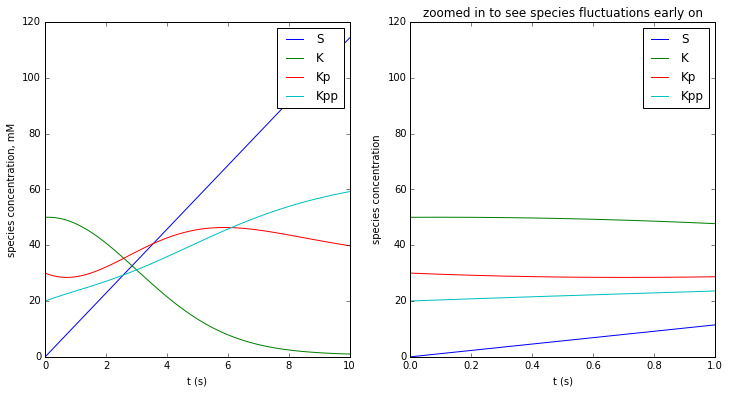

In [40]:
# define rates equations
def rates(y, t, k1, k2, k3, k4, k5):
    return np.asarray([c1 + (N['A'][1] - N['A'][0])*(L/(K-2))/L, 
                       -k1*y[0]*y[1] - k2*y[1] + k3*y[2],
                       k1*y[0]*y[1] + k2*y[1] - k3*y[2] - k4*y[2] + k5*y[3],
                       k4*y[2] -  k5*y[3]])

# plot species
k1 = 1e-2
k2 = 1e-3
k3 = 2e-2
k4 = 2e-1
k5 = 1e-1

#initial concentrations
c2 = 50
c3 = 30
c4 = 20
y0 = np.asarray([c1, c2, c3, c4])/V #initial species concentration


ode = snt.odeint(rates, y0,t, args = (k1, k2, k3, k4, k5))

#find dkpp/dt
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
dkpp = np.diff(ode[:,3])/np.diff(t)
ax.plot(ode[:,3][0:n-1],dkpp)
ax.set_title('bistable solution with intesections at 0')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')

#plot two parameters against each other to determine bistable solution
ax = fig.add_subplot(1,2,2)
ax.plot(k2, k5, 'o')


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['S', 'K', 'Kp', 'Kpp'])

#zoom in 
ax = fig.add_subplot(1,2,2)
tf = 10
t = np.linspace(ti, tf, n)
ode = snt.odeint(rates, y0,t, args = (k1, k2, k3, k4, k5))
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
ax.set_title('zoomed in to see species fluctuations early on')
ax.set_ylabel('species concentration')
ax.legend(['S', 'K', 'Kp', 'Kpp'])
ax.set_xlim([0,1])


plt.show()

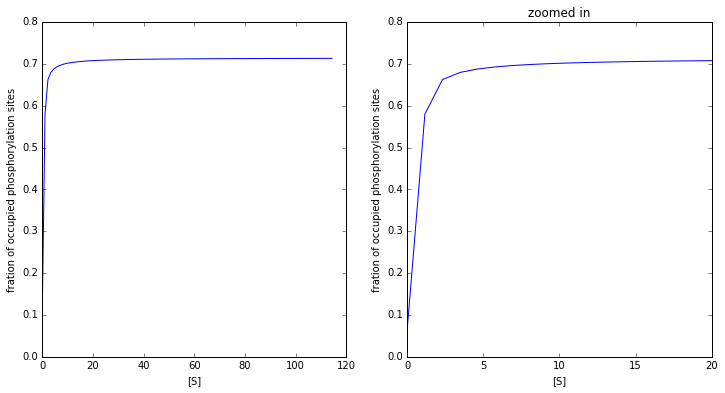

In [105]:
#plot fration of occupied phosphorylation sites to determine of parameters yield cooperativity 
# (sigmoidal as opposed to hyperbolic)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
ax = fig.add_subplot(1,2,2)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
plt.title('zoomed in')
ax.set_xlim([0, 20])

plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning:

divide by zero encountered in power

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning:

invalid value encountered in divide



Hill constant, n: 0.056820760928037
Dissociation constant, kD: 0.5101539611746552


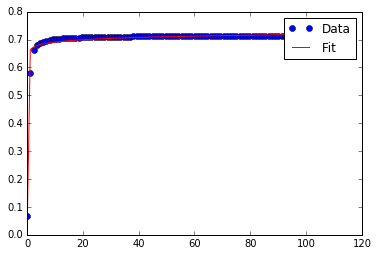

In [106]:
# Hill equation
def Hill(x, n , kD):
    return (x**n)/(kD + x**n)

popt, pcov = curve_fit(Hill, ode[:,0],(ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
plt.plot(ode[:,0],(ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])), 'o', label='Data')
plt.plot(ode[:,0],Hill(ode[:,0], popt[0], popt[1]), 'r-', label='Fit')
plt.legend()
print(''.join(['Hill constant, n: ', str(popt[0]), '\n', 'Dissociation constant, kD: ', str(popt[1])]))
plt.show()

### same deterministic solution as above but now with new definition for autophosphorylation reactions
 new definition forces nonlinearity 

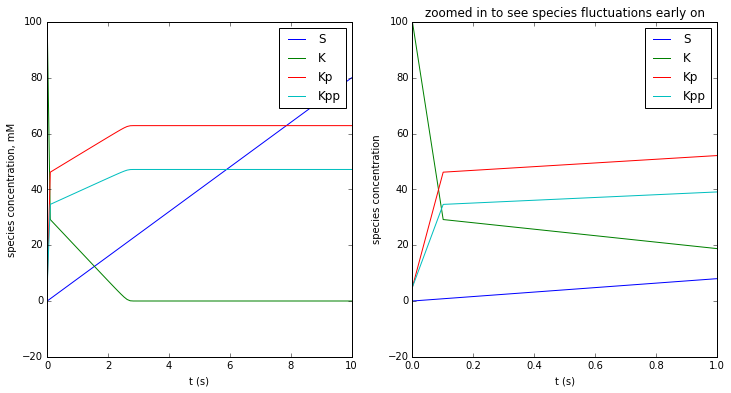

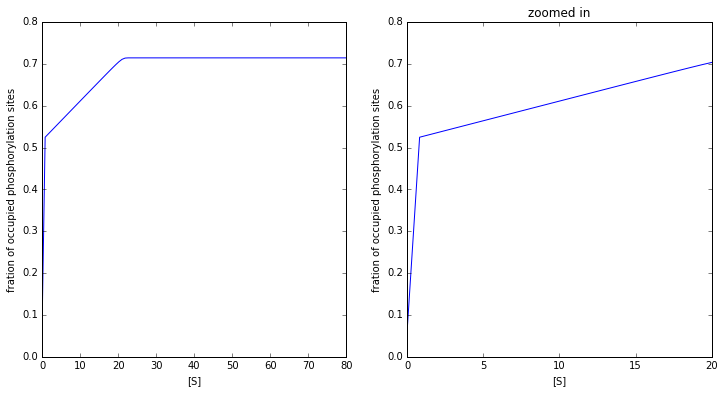

In [107]:
## SPECIES ###
# S    substrate                        (c1)
# K    kinase                           (c2)
# Kp   phosphorylated kinase            (c3)
# Kpp  doubly phosphorlyated kinase     (c4)

### EQUATIONS FOR CELL SIGNALLING ###
# S + K -> S + Kp  (k1)
# K + K -> Kp + K  (k2)
# Kp+ K -> K + K   (k3)
# Kp+Kp -> Kpp+Kp  (k4)
# Kpp+Kp-> Kp+Kp   (k5)


# define rates equations
def rates(y, t):
    return np.asarray([(N['A'][1] - N['A'][0])/tf, 
                      -k1*y[0]*y[1] - 2*k2*y[1]**2 + k2*y[1]**2 + 2*k3*y[2]*y[1] - k3*y[2]*y[1],
                      k1*y[0]*y[1] + k2*y[1]**2 - k3*y[2]*y[1] - 2*k4*y[2]**2 + k4*y[2]**2 + 2*k5*y[3]*y[2] - k5*y[3]*y[2],
                      k4*y[2]**2 -  k5*y[3]*y[2]])

# solve the ODEs
ode = snt.odeint(rates, y0,t)

# plot species
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['S', 'K', 'Kp', 'Kpp'])

#zoom in 
ax = fig.add_subplot(1,2,2)
tf = 10
t = np.linspace(ti, tf, n)
ode = snt.odeint(rates, y0,t)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
ax.set_title('zoomed in to see species fluctuations early on')
ax.set_ylabel('species concentration')
ax.legend(['S', 'K', 'Kp', 'Kpp'])
ax.set_xlim([0,1])

#plot fration of occupied phosphorylation sites to determine of parameters yield cooperativity 
# (sigmoidal as opposed to hyperbolic)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
ax = fig.add_subplot(1,2,2)
ax.plot(ode[:,0], (ode[:,2] + 2*ode[:,3])/(2*(ode[:,1] + ode[:,2] + ode[:,3])))
ax.set_ylabel('fration of occupied phosphorylation sites')
ax.set_xlabel('[S]')
plt.title('zoomed in')
ax.set_xlim([0, 20])

plt.show()

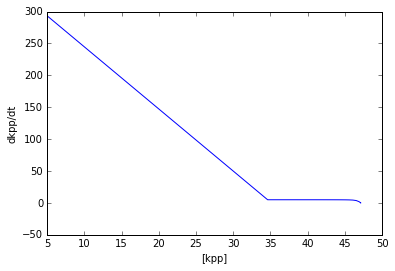

In [109]:
#find dkpp/dt
dkpp = np.diff(ode[:,3])/np.diff(t)
plt.plot(ode[:,3][0:n-1],dkpp)
plt.xlabel('[kpp]')
plt.ylabel('dkpp/dt')
plt.show()